In [31]:
%matplotlib inline

import os
import urllib
import requests
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import earthpy as et
import hydrofunctions as hf

In [2]:
# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Get data set. This may take a minute.
data = et.data.get_data('colorado-flood')

In [4]:
# Set working directory.
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [5]:
# Prettier plotting with seaborn.
sns.set(font_scale=1.5, style="whitegrid")

In [6]:
# Create a map.
hf.draw_map()

In [7]:
# Request data for all streamgage aka stream gauge stations in Colorado.
PR = hf.NWIS(stateCd='CO').get_data()

In [8]:
# List names of the first five sites.
PR.siteName[0:5]

['COLORADO CREEK NEAR SPICER, CO.',
 'GRIZZLY CREEK NEAR SPICER, CO.',
 'BUFFALO CREEK NEAR HEBRON, CO.',
 'GRIZZLY CREEK NEAR HEBRON, CO.',
 'GRIZZLY CREEK NEAR WALDEN, CO']

In [9]:
# Consider the big picture.
# What is the likelihood of observing a 'hundred-year flood' this year, if we observed one last year?
# The probability is still 1/100.
# Analyze streamgage data. Find recurrence interval. Compare to probability.

In [10]:
# There are two types of flood data: Mean daily streamflow and Annual maximum instantaneous streamflow.
# How will these types compare?

In [11]:
# Get data from the hydrofunctions api.
site = "06730500"
start = "1946-05-10"
end = "2018-08-29"

# Request data for this site, during this time period. 'dv' is Daily Value data.
longmont_resp = hf.get_nwis(site, 'dv', start, end)

In [12]:
# Convert to json format in order to use the extract_nwis_df function.
longmont_resp = longmont_resp.json()

In [13]:
# Get site metadata.
hf.get_nwis(site, 'dv').json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/dv/format=json%2C1.1&sites=06730500&parameterCd=00060',
   'criteria': {'locationParam': '[ALL:06730500]',
    'variableParam': '[00060]',
    'parameter': []},
   'note': [{'value': '[ALL:06730500]', 'title': 'filter:sites'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2021-05-03T17:28:56.581Z', 'title': 'requestDT'},
    {'value': '09fde350-ac35-11eb-bbc1-2cea7f58f5ca', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'vaas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': '

In [14]:
# Get the discharge data in a pandas DataFrame format.
longmont_discharge = hf.extract_nwis_df(longmont_resp)
longmont_discharge.head()

,USGS:06730500:00060:00003,USGS:06730500:00060:00003_qualifiers
datetime,,
1946-05-10,16.0,A
1946-05-11,19.0,A
1946-05-12,9.0,A
1946-05-13,3.0,A
1946-05-14,7.8,A


In [15]:
# For this example, rename the columns for readability. Skip this step when you have multiple sites.
longmont_discharge.columns = ["discharge", "flag"]
longmont_discharge.head()

,discharge,flag
datetime,,
1946-05-10,16.0,A
1946-05-11,19.0,A
1946-05-12,9.0,A
1946-05-13,3.0,A
1946-05-14,7.8,A


In [16]:
longmont_discharge.tail()

,discharge,flag
datetime,,
2018-08-25,9.86,A
2018-08-26,7.02,A
2018-08-27,4.05,A
2018-08-28,2.67,A
2018-08-29,3.36,A


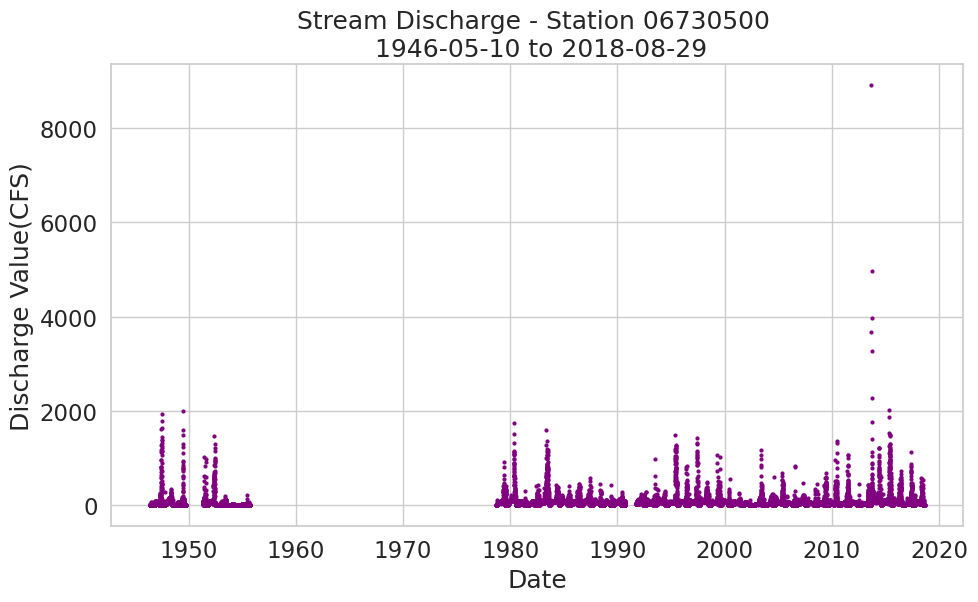

In [32]:
# Plot using matplotlib.
fig, ax = plt.subplots(figsize=(11, 6))

ax.scatter(x=longmont_discharge.index,
          y=longmont_discharge["discharge"],
          marker='o',
          s=4,
          color="purple")

ax.set(xlabel="Date", ylabel="Discharge Value(CFS)",
      title=f"Stream Discharge - Station {site} \n {start} to {end}")

plt.show()

In [18]:
# Snag. My plt.show() call gave me this error:
# UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
# Solution. I checked stackoverflow.
# First, I guessed I needed to install tkinter.
# But I checked both the system and virtual env python, and tkinter was up to date.
# Then I added %matplotlib inline above my import statements. This tells matplotlib to put graphs next to their cells.
# For interactivity use %matplotlib notebook.

In [19]:
# Calculate the annual maximum value from the daily mean values. 
# Compare this with the instantaneous annual maxiumum dataset from USGS.

In [20]:
# Add a year column for convenience.
longmont_discharge["year"] = longmont_discharge.index.year

In [21]:
# Calc annual max by resampling.
longmont_discharge_annual_max = longmont_discharge.resample('AS').max()
longmont_discharge_annual_max.head()

,discharge,flag,year
datetime,,,
1946-01-01,99.0,A,1946.0
1947-01-01,1930.0,A,1947.0
1948-01-01,339.0,A,1948.0
1949-01-01,2010.0,A,1949.0
1950-01-01,NaN,NaN,NaN


In [22]:
# Import USGS dataset.
url = "https://nwis.waterdata.usgs.gov/nwis/peak?site_no=06730500&agency_cd=USGS&format=rdb"
download_path = os.path.join("data", "colorado-flood", "downloads", "annual-peak-flow.txt")
urllib.request.urlretrieve(url, download_path)

('data/colorado-flood/downloads/annual-peak-flow.txt',
 <http.client.HTTPMessage at 0x7f9de5192280>)

In [23]:
# A function that counts the number of lines with a comment.
def count_the(file_url):
    r = requests.get(file_url, stream=True)
    file = r.text
    count = 0
    for line in file:
        if line.startswith('#'):
            count += 1
    return count

# Find lines to skip.
lines_to_skip = count_the(url) + 1

In [24]:
lines_to_skip

73

In [25]:
# Open the data in pandas.
usgs_annual_max = pd.read_csv(download_path,
                             skiprows=[lines_to_skip],
                             comment='#',
                             sep='\t',
                             usecols=['peak_dt', 'peak_va'],
                             parse_dates=['peak_dt'],
                             index_col='peak_dt')
usgs_annual_max.head()

,peak_va
peak_dt,
1927-07-29,407.0
1928-06-04,694.0
1929-07-23,530.0
1930-08-18,353.0
1931-05-29,369.0


In [26]:
# Add a year column for convenient plotting.
usgs_annual_max["year"] = usgs_annual_max.index.year

# Check for duplicates. Returns years with duplicates.
usgs_annual_max[usgs_annual_max.duplicated(subset="year") == True]

,peak_va,year
peak_dt,,
1947-10-15,721.0,1947
1993-10-18,497.0,1993


In [27]:
# Remove duplicate -- keep max value.
usgs_annual_max = usgs_annual_max.sort_values('peak_va', ascending=False).drop_duplicates('year').sort_index()

In [28]:
# Check that duplicate removal worked.
usgs_annual_max[usgs_annual_max.duplicated(subset="year") == True]

,peak_va,year
peak_dt,,


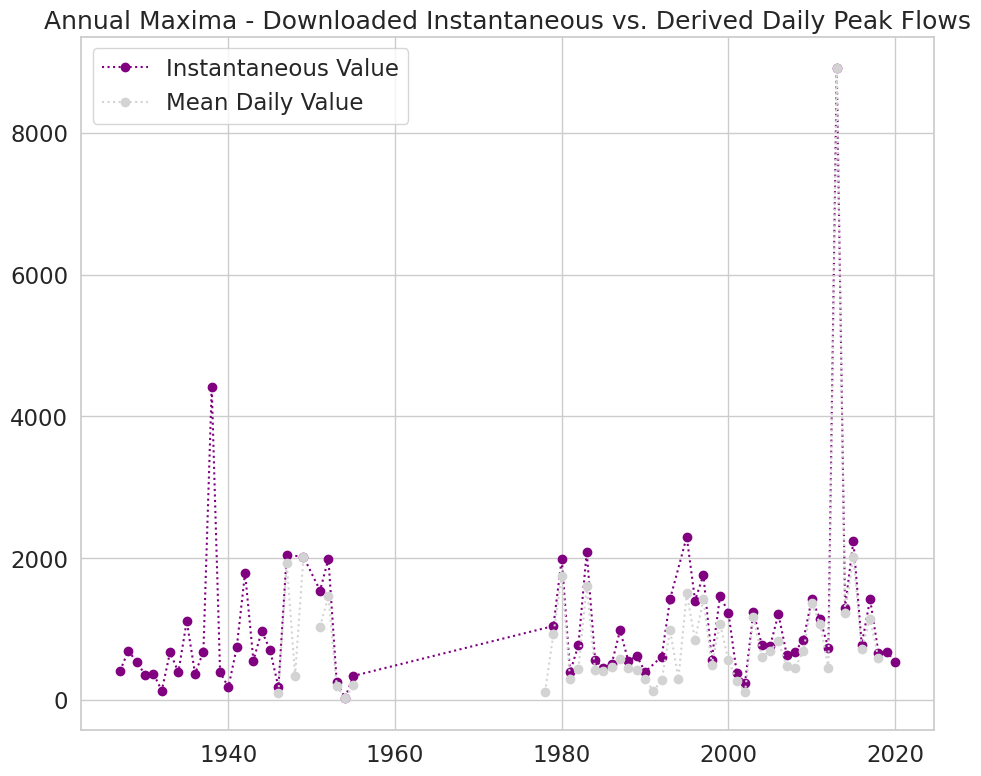

In [33]:
# Compare your calculated annual max against the USGS annual max.
fix, ax = plt.subplots(figsize=(11, 9))
ax.plot(usgs_annual_max["year"],
        usgs_annual_max["peak_va"],
        color="purple",
        linestyle=':',
        marker='o',
        label="Instantaneous Value")

ax.plot(longmont_discharge_annual_max["year"],
        longmont_discharge_annual_max["discharge"],
        color="lightgrey",
        linestyle=':',
        marker='o', label="Mean Daily Value")
ax.legend()
ax.set_title(
    "Annual Maxima - Downloaded Instantaneous vs. Derived Daily Peak Flows")

plt.show()

In [36]:
# Calculate the return period.

def calc_return(df, colname):
    """Docs"""
    # Sort data in ascending order.
    sorted_data = df.sort_values(by=colname)
    # Count observations.
    n = sorted_data.shape[0]
    # Add a numbered column 1 -> n for rank.
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    # Calc probability.
    sorted_data["probability"] = (n - sorted_data["rank"] + 1) / (n + 1)
    sorted_data["return-years"] = (1 / sorted_data["probability"])
    return sorted_data

In [37]:
longmont_prob = calc_return(longmont_discharge, "discharge")
longmont_prob["return-years"] = longmont_prob["return-years"] / 365
longmont_prob["probability"] = longmont_prob["probability"] * 365
longmont_prob.tail()

,rank,discharge,flag,year,probability,return-years
datetime,,,,,,
2013-09-16,17078,3270.0,A e,2013,0.106831,9.360548
2013-09-12,17079,3680.0,A,2013,0.085465,11.700685
2013-09-15,17080,3970.0,A e,2013,0.064099,15.600913
2013-09-14,17081,4970.0,A e,2013,0.042733,23.401370
2013-09-13,17082,8910.0,A e,2013,0.021366,46.802740


In [39]:
usgs_annual_prob = calc_return(usgs_annual_max, "peak_va")
usgs_annual_prob.tail()

,rank,peak_va,year,probability,return-years
peak_dt,,,,,
1983-05-19,63,2090.0,1983,0.073529,13.600000
2015-05-09,64,2240.0,2015,0.058824,17.000000
1995-05-17,65,2300.0,1995,0.044118,22.666667
1938-09-03,66,4410.0,1938,0.029412,34.000000
2013-09-13,67,8910.0,2013,0.014706,68.000000


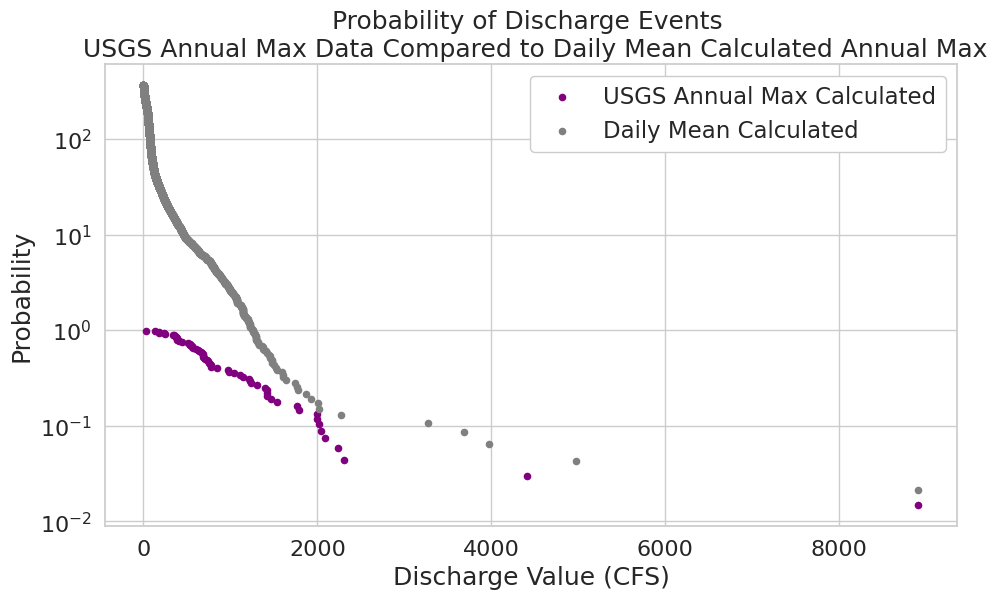

In [40]:
# Compare the two datasets.
fig, ax = plt.subplots(figsize=(11,6))

usgs_annual_prob.plot.scatter(x='peak_va',
                             y='probability',
                             title="Probability ",
                             ax=ax,
                             color='purple',
                             fontsize=16,
                             logy=True,
                             label="USGS Annual Max Calculated")

longmont_prob.plot.scatter(x='discharge',
                          y='probability',
                          title="Probability ",
                          ax=ax,
                          color='grey',
                          fontsize=16,
                          logy=True,
                          label="Daily Mean Calculated")

ax.legend(frameon=True,
         framealpha=1)

ax.set_xlabel("Discharge Value (CFS)")
ax.set_ylabel("Probability")
ax.set_title("Probability of Discharge Events \n USGS Annual Max Data Compared to Daily Mean Calculated Annual Max")
plt.show()